In [2]:
import numpy as np #Deal with numbers and arrays
import pandas as pd #Create dataframes and sort/clean data faster

import matplotlib.pyplot as plt #Visualization module
import pathlib as pl
import seaborn as sns #Makes matplotlib prettier

#This blocks imports everything needed from sklearn(models, procession packages, and metrics)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import plotly.express as px #Module for dynamic data visualization

## Load data

In [3]:
path = pl.Path(f"./data/21")
dfraw21 = pd.DataFrame()
for file in path.iterdir():
    df= pd.read_csv(path/file.name,index_col=False,usecols=['latitude', 'longitude',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds','price','number_of_reviews',
       'calculated_host_listings_count','minimum_nights','room_type'])
    df=df.dropna(subset=['price'])
    df["price"] = df["price"].apply(lambda x: x.replace("$",""))
    df["price"] = df["price"].apply(lambda x: x.replace(",",""))
    df["price"] = df["price"].astype (np.float32)
    df["price"] = df["price"].astype (np.int32)
    df['bathrooms'] = df['bathrooms_text'].str.extract("(\d*\.?\d+)", expand=False)
    df['bathrooms'] = np.where(df['bathrooms_text'].str.contains("half", case=False, na=False), 0.5, df['bathrooms'])
    dfraw21 = pd.concat([dfraw21,df])
dfraw21 = dfraw21.dropna()
dfraw21 = dfraw21.drop("bathrooms_text", axis = 1)
dfraw21.isnull().sum()

latitude                          0
longitude                         0
room_type                         0
accommodates                      0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
bathrooms                         0
dtype: int64

## Data Treatment
See types.

In [4]:
dfraw21.dtypes

latitude                          float64
longitude                         float64
room_type                          object
accommodates                        int64
bedrooms                          float64
beds                              float64
price                               int32
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
bathrooms                          object
dtype: object

Convert 64 int to 32, and object to number

In [5]:
dfraw21["accommodates"] = dfraw21["accommodates"].astype(np.int32, copy = False)
dfraw21["bedrooms"] = dfraw21["bedrooms"].astype(np.int32, copy = False)
dfraw21["beds"] = dfraw21["beds"].astype(np.int32, copy = False)
dfraw21["minimum_nights"] = dfraw21["minimum_nights"].astype(np.int32, copy = False)
dfraw21["number_of_reviews"] = dfraw21["number_of_reviews"].astype(np.int32, copy = False)
dfraw21["calculated_host_listings_count"] = dfraw21["calculated_host_listings_count"].astype(np.int32, copy = False)
dfraw21["latitude"] = dfraw21["latitude"].astype(np.float32, copy = False)
dfraw21["longitude"] = dfraw21["longitude"].astype(np.float32, copy = False)
dfraw21["bathrooms"] = dfraw21["bathrooms"].astype(np.float32, copy = False)

Remove anomalies

6106 rows removed
65503 total rows and 11 total columns


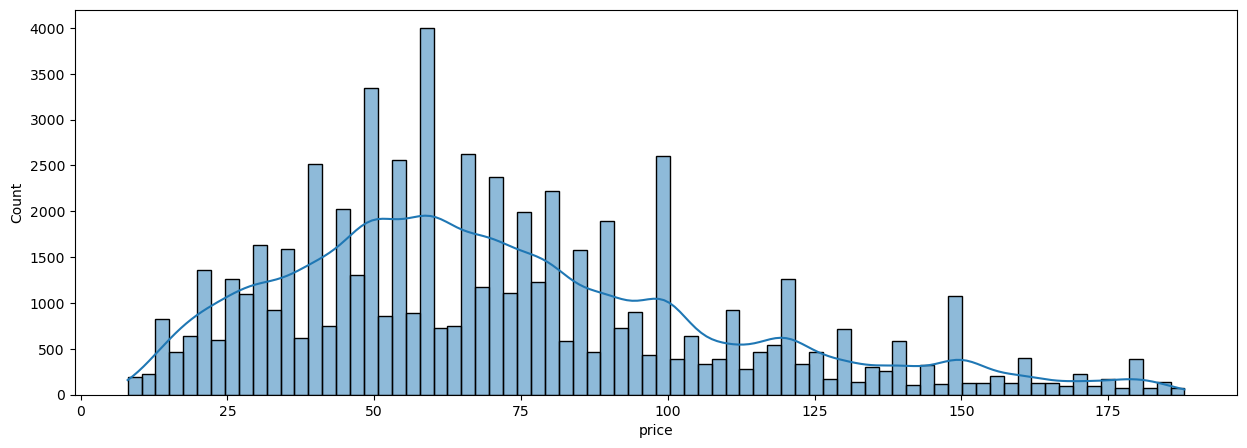

In [6]:
def outlier (col):
    q1 = col.quantile (0.25)
    q3 = col.quantile (0.75)
    iqr = q3 - q1
    lenght = 1.5
    return q1 - lenght * iqr, q3 + lenght * iqr

def hist (col):
    plt.figure (figsize = (15,5))
    sns.histplot (col, kde = True)

def remove (ds, col):
    before = ds.shape [0]
    low, up = outlier (ds [col])
    ds = ds.loc [(ds [col] >= low) & (ds [col] <= up), :]
    return ds, before - ds.shape [0]
dfraw21, removed = remove (dfraw21, "price")

aux = dfraw21 ["room_type"].value_counts ()
for kind in aux.index:
    if aux [kind] < 15000:
        dfraw21.loc [dfraw21 ["room_type"] == kind, "room_type"] = "Rooms"
        
print (f"{removed} rows removed")
hist (dfraw21 ["price"])
print (f"{dfraw21.shape [0]} total rows and {dfraw21.shape [1]} total columns")

In [7]:
dfraw21["room_type"] = np.where(dfraw21["room_type"] == "Rooms", 0, 1)
dfraw21["room_type"] = dfraw21["room_type"].astype(np.int32, copy = False)

Some functions to evaluate methods

In [10]:
def evaluate(model, ytest, prediction):
    rmse = np.sqrt (mean_squared_error (ytest, prediction))
    mae = mean_absolute_error (ytest, prediction)
    r2 = r2_score (ytest, prediction)
    return f"\n-----\nModel: {model}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2%}\n-----\n"

y = dfraw21['price']
columns_dropped = ['price']

param_grid_knn = {'n_neighbors': range(1, 21)}

param_distributions = {
    'C': uniform(0.1, 100),
    'epsilon': uniform(0.01, 1)
}

models = {'SVR': SVR(),
          'KNeighborsRegressor': KNeighborsRegressor()
}

X = dfraw21.drop(columns_dropped, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

for name, model in models.items():
    if name == 'KNeighborsRegressor':
        random_search = RandomizedSearchCV(model, param_distributions=param_grid_knn, cv=5)
    else:
        random_search = RandomizedSearchCV(model, param_distributions=param_distributions, cv=5)
    random_search.fit(X_train, y_train)
    predictions = random_search.predict(X_test)
    print(random_search.best_params_)
    print(evaluate(name, y_test, predictions))

{'C': 71.21818954206266, 'epsilon': 0.16819429435540822}

-----
Model: SVR
RMSE: 31.34
MAE: 23.11
R2: 28.94%
-----

{'n_neighbors': 3}

-----
Model: KNeighborsRegressor
RMSE: 26.83
MAE: 18.85
R2: 47.92%
-----

